In [1]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
import os

In [2]:
# Drawing functions

def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (10,10)

# ATSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost (length, distance) $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> The tour (a directed cycle that touch exactly once all $n$ nodes) of minimum cost (length, distance)  


### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} c_{ij} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
\sum_{(i,j) \in A(S)} x_{ij} &\le |S| - 1 \;\; \forall S \subset N, |S| \ge 2 \;\; \text{(SEC)}\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [8]:
# Read the graph in the graphML format

args.filename = 'atsp19062017.gml'
args.figsize =  (20,30)

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")
print(G.is_directed())

G has 28 nodes and 756 edges
True


# ATSP: Branch-and-cut

## SEC separation embedded into Lazy Callback

$$ \sum_{i \in S, j \in \bar S} x_{ij} \ge 1 \;\; \forall S, 2 \le |S| \le |N|-1 $$

In [9]:
def subtourseparation (G, x):
   
    for i,j in G.edges():
        G[i][j]['capacity'] = x[i,j].x
        
    for i in list(G.nodes())[1:]:
        cut_val, cut = nx.minimum_cut(G,1,i)
        
        if cut_val < 0.99999:
            print ('Found violated subtour inequality')
            
            if len(cut[0]) < len(cut[1]):
                subtour = (list(cut[0]))
            else:
                subtour = (list(cut[1]))
            print (subtour)
            return subtour
        
    return None

# The separation routine is transformed into a callback
def SEC_lazy_callback (model, where):

        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        xrel = model.cbGetSolution(x)
        G = model._graph
                
        for i,j in G.edges():
            G[i][j]['capacity'] = xrel[i,j]
        
        for i in list(G.nodes())[1:]:
            cut_val, cut = nx.minimum_cut(G,1,i)
        
            if cut_val < 0.99999:
                if len(cut[0]) < len(cut[1]):
                    subtour = (list(cut[0]))
                else:
                    subtour = (list(cut[1]))
        
                
                subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
                
                #print (subtour, sum( xrel[i,j] for i,j in subtouredges))
                
                model.cbLazy(gb.quicksum(x[i,j] for i,j in subtouredges) <= len(subtour) - 1)
                break
          

## **Ex1.1->** Find the most profitable location of the warehouse and the optimal delivering tour

Discarded solution information
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 434 rows, 756 columns and 2268 nonzeros
Model fingerprint: 0x13abd5fd
Variable types: 0 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 41977.000000
Presolve removed 55 rows and 54 columns
Presolve time: 0.01s
Presolved: 379 rows, 702 columns, 2054 nonzeros
Variable types: 0 continuous, 702 integer (702 binary)

Root relaxation: objective 1.490400e+04, 71 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

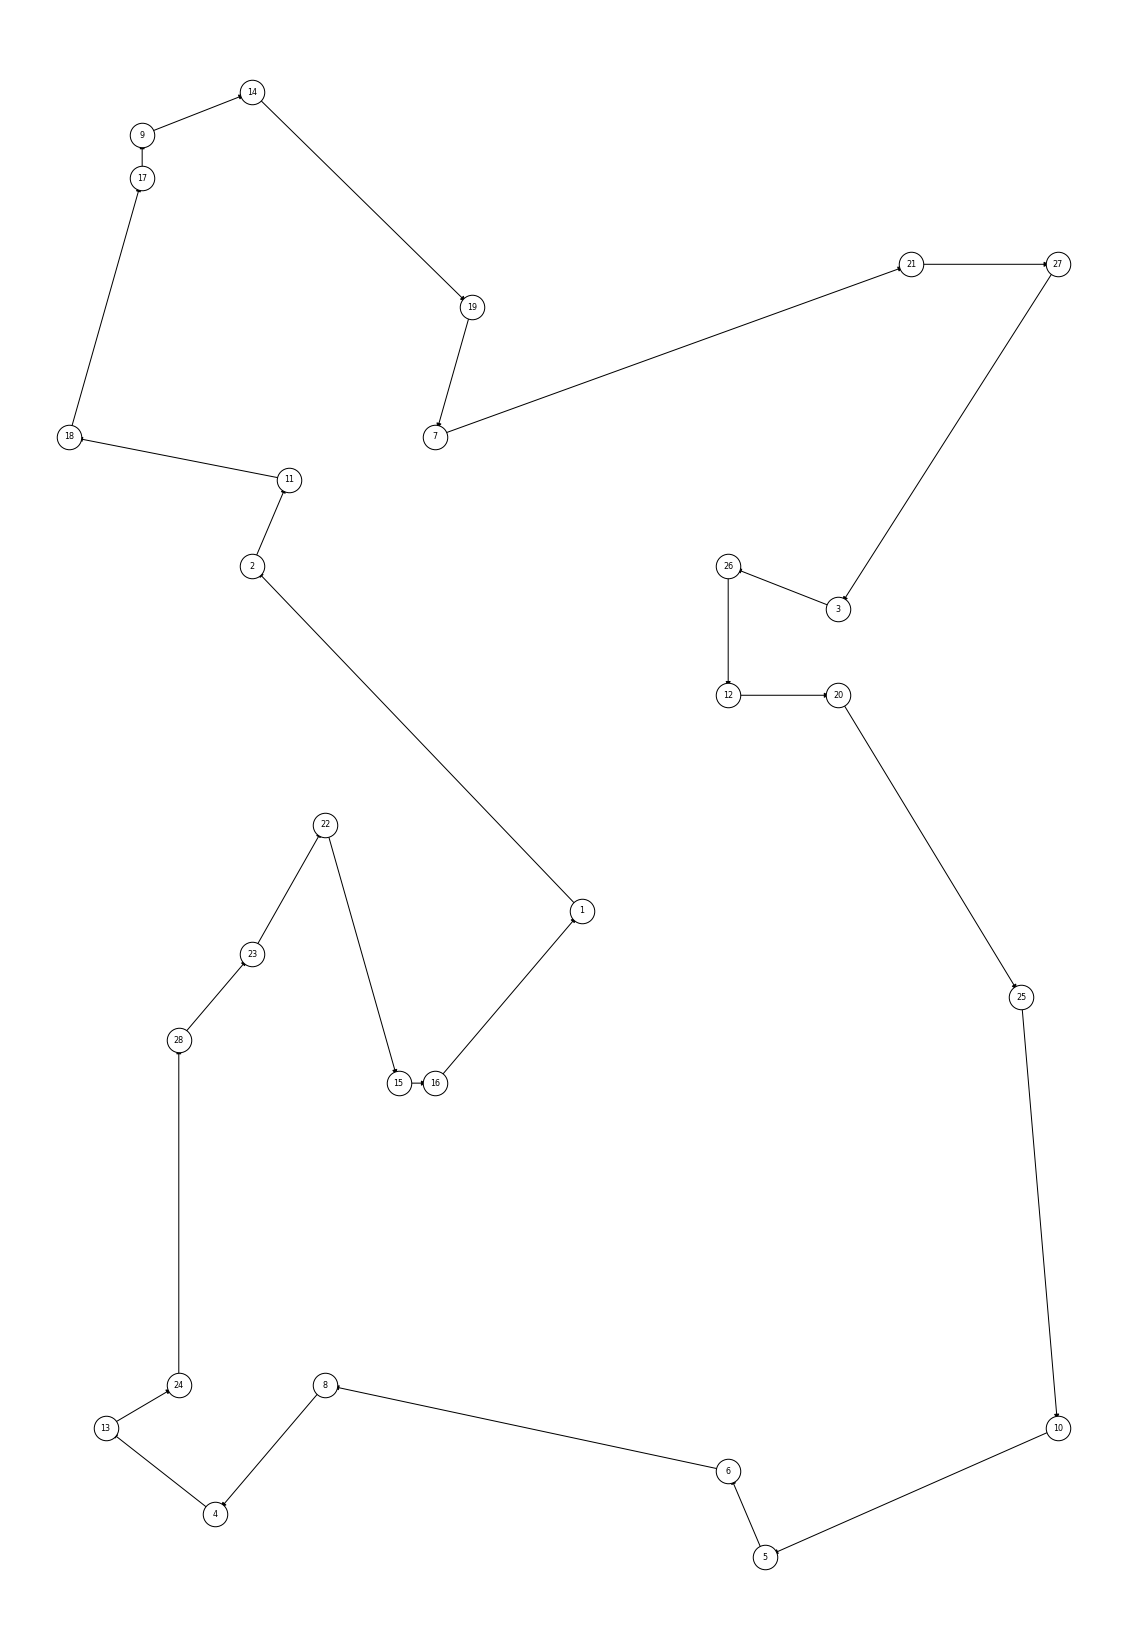

Discarded solution information
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 434 rows, 756 columns and 2268 nonzeros
Model fingerprint: 0x310d0c58
Variable types: 0 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 55 rows and 54 columns
Presolve time: 0.01s
Presolved: 379 rows, 702 columns, 2054 nonzeros
Variable types: 0 continuous, 702 integer (702 binary)
Found heuristic solution: objective 47885.000000

Root relaxation: objective 1.395800e+04, 64 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

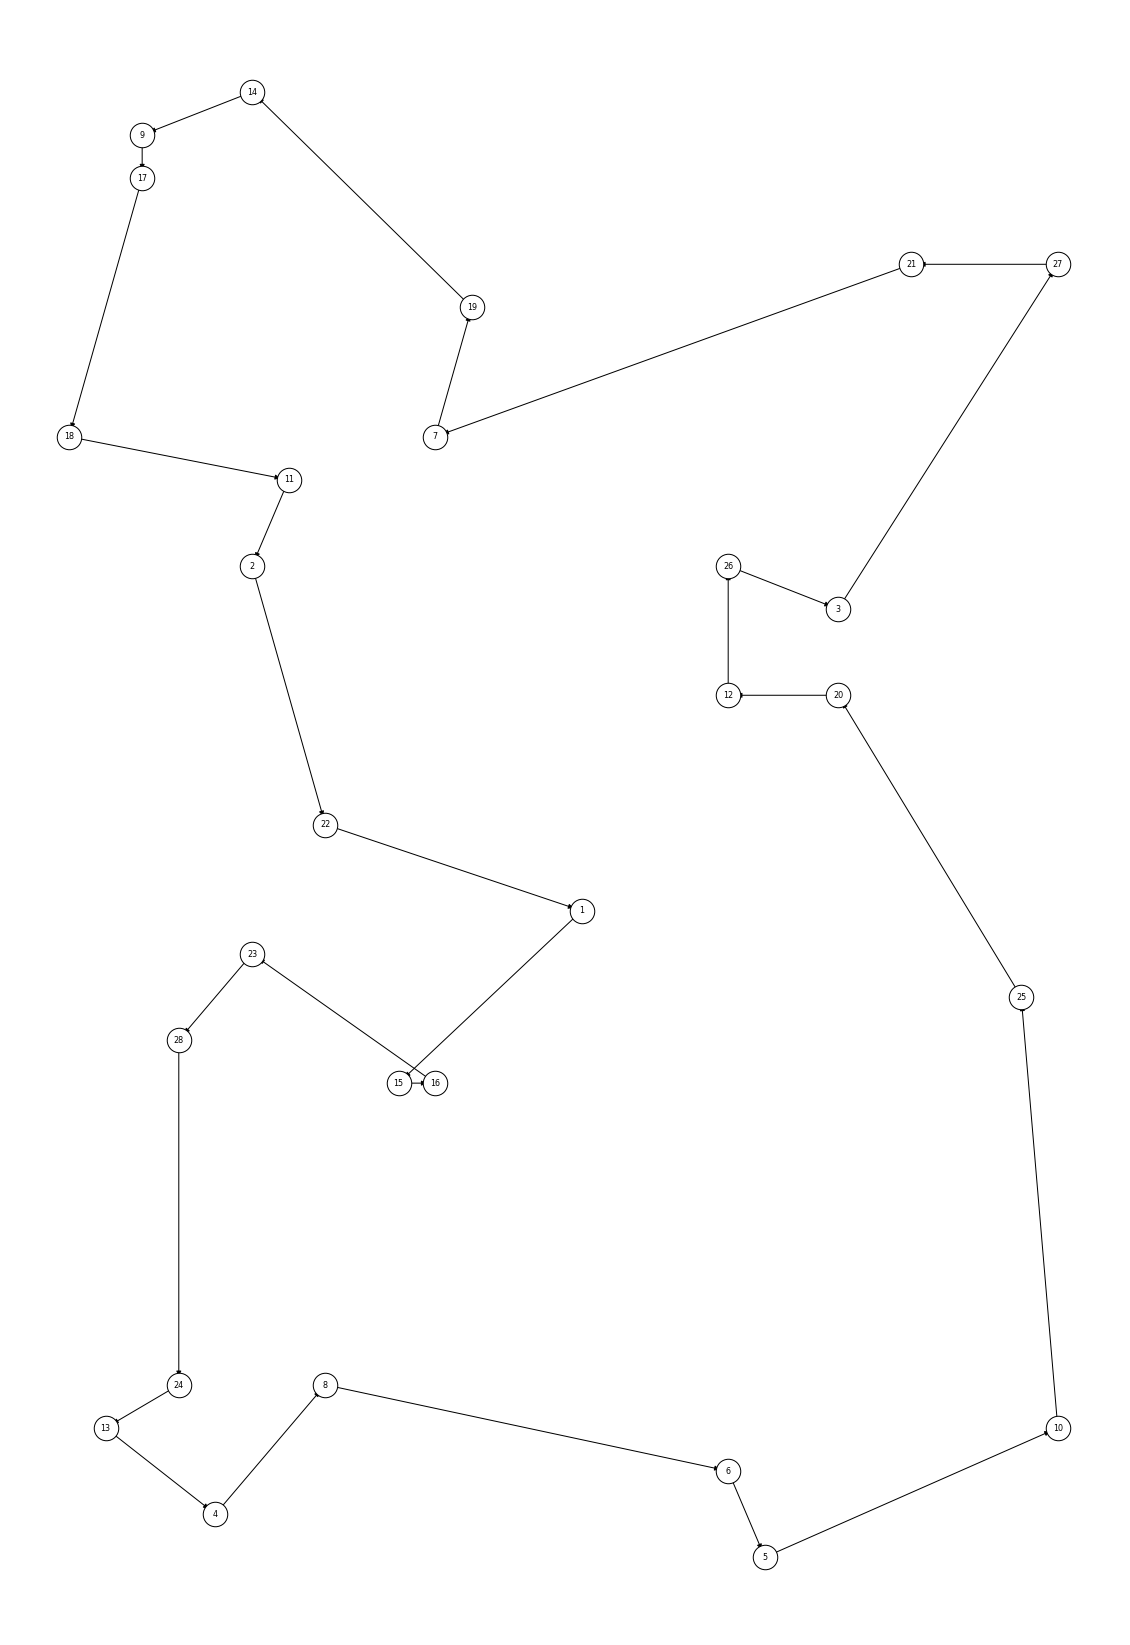

Discarded solution information
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 434 rows, 756 columns and 2268 nonzeros
Model fingerprint: 0x2c3fbfdc
Variable types: 0 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 55 rows and 54 columns
Presolve time: 0.01s
Presolved: 379 rows, 702 columns, 2054 nonzeros
Variable types: 0 continuous, 702 integer (702 binary)

Root relaxation: objective 1.459900e+04, 68 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 14599.0000    0   28          - 14599.000

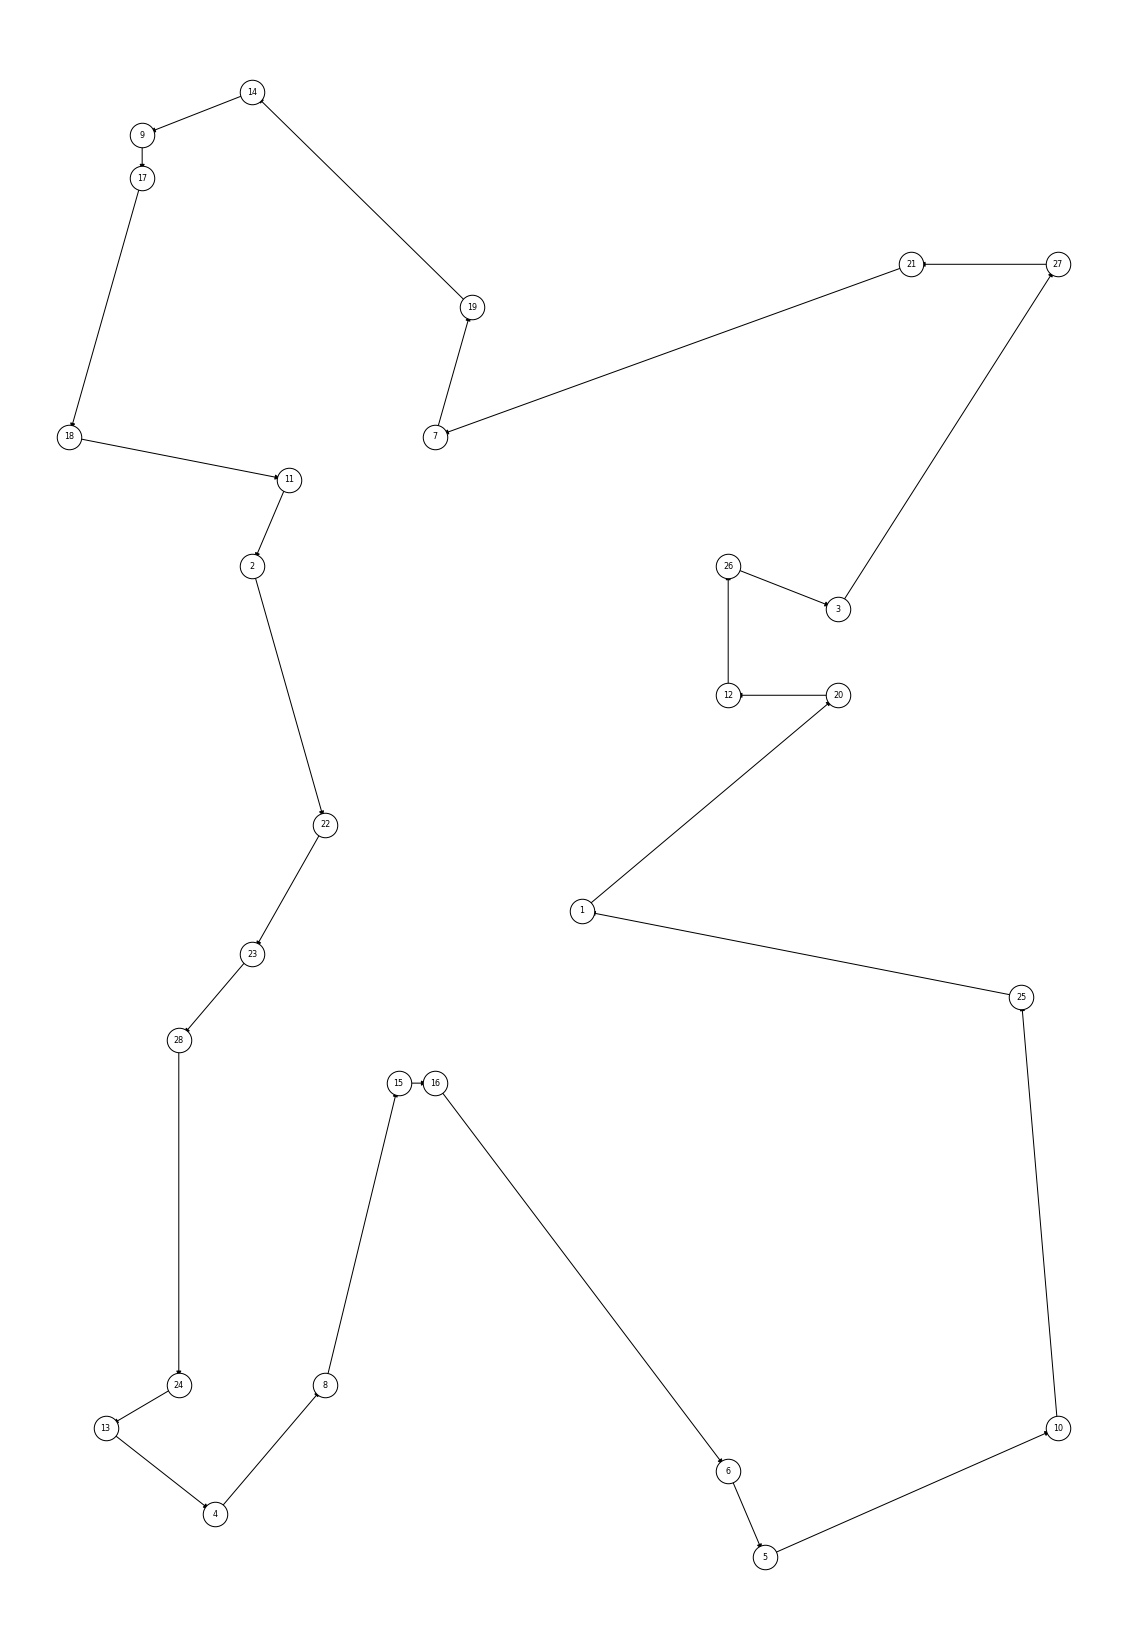

In [10]:
root = 1

solutions = []
wharehouses = [2,15,20]

for i in wharehouses:
    atsp_sec = gb.Model()

    x = atsp_sec.addVars(G.edges(),
                         obj=[G[i][j]['dist'] for i,j in G.edges()],
                         vtype=gb.GRB.BINARY, name='x')

    atsp_sec.write('atsp_sec.lp')

    # FS constraints
    atsp_sec.addConstrs((x.sum(i,'*') == 1 for i in G.nodes()), name='FS')
    # RS constraints
    atsp_sec.addConstrs((x.sum('*',i) == 1 for i in G.nodes()), name='RS')
    # SEC with |S|=2
    atsp_sec.addConstrs((x[i,j] + x[j,i] <= 1 for i,j in G.edges() if j > i), name='SUB2')

    # fix the node number i form the list of possible wharehouses to be the first visited
    x[1,i].lb=1
    x[1,i].ub=1

    atsp_sec.update()
    atsp_sec.write('atsp.lp')

    # Graph G and variables x are made available to Gurobi model
    atsp_sec._graph = G
    atsp_sec._vars = x

    atsp_sec.reset()
    atsp_sec.Params.lazyConstraints = 1
    atsp_sec.optimize(SEC_lazy_callback)
    
    solutions.append(atsp_sec.objVal)
    DrawSol(G, x)

In [11]:
for i in range(len(wharehouses)):
    print("Solution with wharehouse", wharehouses[i] , "is:", solutions[i])

Solution with wharehouse 2 is: 15861.0
Solution with wharehouse 15 is: 15613.0
Solution with wharehouse 20 is: 15951.999979499995


#### The most profitable location of the warehouse is the one in node 15 and it's value is 15613